In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [120]:
PATH_TO_FILE="./ai4i2020.csv"
df = pd.read_csv(PATH_TO_FILE)
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [121]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  str    
 2   Type                     10000 non-null  str    
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9), str(2)
me

In [122]:
UDI_COL = "UDI"
PRODUCT_ID_COL = "Product ID"
TYPE_COL = "Type"
AIR_TEMP_COL = "Air temperature [K]"
PROCESS_TEMP_COL = "Process temperature [K]"
RPM_COL = "Rotational speed [rpm]"
TORQUE_COL = "Torque [Nm]"
TOOL_WEAR_COL = "Tool wear [min]"
MACHINE_FAILURE_COL = "Machine failure"
TWF_COL = "TWF"
HDF_COL = "HDF"
PWF_COL = "PWF"
OSF_COL = "OSF"
RNF_COL = "RNF"

NUMERIC_FEATURES = [AIR_TEMP_COL, PROCESS_TEMP_COL, RPM_COL, TORQUE_COL, TOOL_WEAR_COL]
SUB_FAILURES = [TWF_COL, HDF_COL, PWF_COL, OSF_COL, RNF_COL]

## Phase 1 - Data Audit & Risk Evaluation

In [123]:
df.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [124]:
# Check for impossible values
print(f"Negative torque: {(df[TORQUE_COL] < 0).sum()}")
print(f"Air temp out of range (250-350K): {((df[AIR_TEMP_COL] < 250) | (df[AIR_TEMP_COL] > 350)).sum()}")
print(f"Process temp <= Air temp: {(df[PROCESS_TEMP_COL] <= df[AIR_TEMP_COL]).sum()}")

Negative torque: 0
Air temp out of range (250-350K): 0
Process temp <= Air temp: 0


In [125]:
print(f"Duplicated rows: {df.duplicated().sum()}")
print(f"UDI unique: {df[UDI_COL].is_unique}")

Duplicated rows: 0
UDI unique: True


In [126]:
# Inconsistent failure flags
no_fail_violations = df[(df[MACHINE_FAILURE_COL] == 0) & (df[SUB_FAILURES].sum(axis=1) > 0)]
fail_violations = df[(df[MACHINE_FAILURE_COL] == 1) & (df[SUB_FAILURES].sum(axis=1) == 0)]
print(f"Machine=0 but has sub-failure: {len(no_fail_violations)}")
print(f"Machine=1 but no sub-failure: {len(fail_violations)}")

Machine=0 but has sub-failure: 18
Machine=1 but no sub-failure: 9


### Industrial Audit Summary
- No missing values across all 14 columns
- No impossible values: all torque positive (min 3.8 Nm), temperatures in valid range (295-313 K)
- No duplicate records, UDI is unique identifier (1-10000)
- **Data inconsistency found**: 18 records have sub-failure flags (TWF/HDF/PWF/OSF/RNF) but Machine failure=0
- **Data inconsistency found**: 9 records have Machine failure=1 but no sub-failure flags set
- **Risk for real-time control**: Inconsistent flags could cause system to misclassify 27 dangerous states, potentially delaying emergency shutdowns

## Phase 2 - Sensor Behavior Analysis

In [127]:
normal_df = df[df[MACHINE_FAILURE_COL] == 0]
failed_df = df[df[MACHINE_FAILURE_COL] == 1]

sensor_stats = []
for col in NUMERIC_FEATURES:
    sensor_stats.append({
        'Sensor': col,
        'Mean': df[col].mean(),
        'Std': df[col].std(),
        'IQR': df[col].quantile(0.75) - df[col].quantile(0.25),
        'Normal_Mean': normal_df[col].mean(),
        'Failed_Mean': failed_df[col].mean(),
        'Diff%': ((failed_df[col].mean() - normal_df[col].mean()) / normal_df[col].mean() * 100)
    })

pd.DataFrame(sensor_stats).round(2)

,Sensor,Mean,Std,IQR,Normal_Mean,Failed_Mean,Diff%
0,Air temperature [K],300.00,2.00,3.2,299.97,300.89,0.30
1,Process temperature [K],310.01,1.48,2.3,310.00,310.29,0.10
2,Rotational speed [rpm],1538.78,179.28,189.0,1540.26,1496.49,-2.84
3,Torque [Nm],39.99,9.97,13.6,39.63,50.17,26.59
4,Tool wear [min],107.95,63.65,109.0,106.69,143.78,34.76


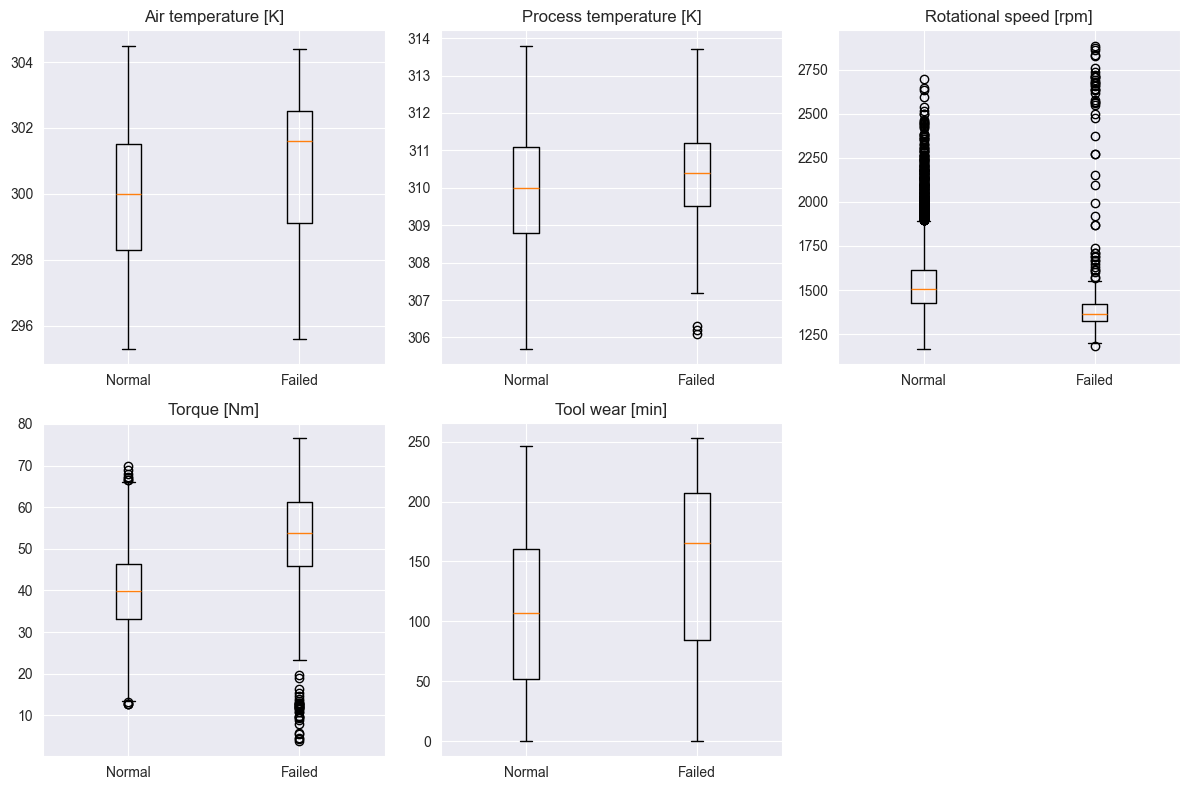

In [128]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, col in enumerate(NUMERIC_FEATURES):
    ax = axes[i // 3, i % 3]
    ax.boxplot([normal_df[col], failed_df[col]], tick_labels=['Normal', 'Failed'])
    ax.set_title(col)
axes[1, 2].axis('off')
plt.tight_layout()
plt.show()

### Sensor Behavior Interpretation
- **Tool wear**: Failed machines show 34.8% higher wear (143.8 vs 106.7 min) - strongest early warning signal
- **Torque**: Failed machines show 26.6% higher torque (50.2 vs 39.6 Nm) - strong indicator of mechanical stress
- **RPM**: Failed machines show 2.8% lower speed (1496 vs 1540 rpm) - moderate signal
- **Temperature**: Minimal difference (<0.5%) - not useful for early warning

## Phase 3 - Industrial Anomaly Detection

In [129]:
anomaly_results = []
for col in NUMERIC_FEATURES:
    z_scores = np.abs(stats.zscore(df[col]))
    z_anomalies = z_scores > 3
    
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    iqr_anomalies = (df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)
    
    z_in_failed = z_anomalies[df[MACHINE_FAILURE_COL] == 1].sum()
    iqr_in_failed = iqr_anomalies[df[MACHINE_FAILURE_COL] == 1].sum()
    
    anomaly_results.append({
        'Sensor': col,
        'Z_Anomalies': z_anomalies.sum(),
        'Z_in_Failed': z_in_failed,
        'IQR_Anomalies': iqr_anomalies.sum(),
        'IQR_in_Failed': iqr_in_failed
    })

pd.DataFrame(anomaly_results)

,Sensor,Z_Anomalies,Z_in_Failed,IQR_Anomalies,IQR_in_Failed
0,Air temperature [K],0,0,0,0
1,Process temperature [K],0,0,0,0
2,Rotational speed [rpm],164,33,418,35
3,Torque [Nm],25,24,69,62
4,Tool wear [min],0,0,0,0


### Anomaly Decision
**Decision: Keep anomalies as risk indicators, do not remove.**

Justification:
- **Torque**: 96% of Z-score anomalies (24/25) occur in failed machines - clearly pre-failure signals
- **RPM**: 20% of Z-score anomalies (33/164) in failed machines vs 3.4% baseline failure rate - 6x overrepresentation
- **Temperature**: No anomalies detected - confirms it's not useful for anomaly-based failure detection
- Removing these anomalies would eliminate critical predictive information for maintenance models

## Phase 4 - Risk Segmentation

In [130]:
df['Tool_Wear_Risk'] = pd.cut(df[TOOL_WEAR_COL], 
                              bins=[-1, 100, 200, float('inf')], 
                              labels=['Normal', 'Maintenance Soon', 'Critical'])

df['Temp_Diff'] = df[PROCESS_TEMP_COL] - df[AIR_TEMP_COL]
# Low temp diff = poor heat dissipation = HDF risk (per dataset documentation: HDF when diff < 8.6K)
df['Temp_Risk'] = pd.cut(df['Temp_Diff'], 
                         bins=[0, 8.6, 10, float('inf')], 
                         labels=['Critical (HDF Risk)', 'Warning', 'Stable'])

In [131]:
def failure_rate_by_risk(df, risk_col):
    result = df.groupby(risk_col).agg(
        Total=(MACHINE_FAILURE_COL, 'count'),
        Failures=(MACHINE_FAILURE_COL, 'sum')
    )
    result['Failure_Rate_%'] = (result['Failures'] / result['Total'] * 100).round(2)
    return result

print("Tool Wear Risk:")
print(failure_rate_by_risk(df, 'Tool_Wear_Risk'))
print("\nTemperature Risk:")
print(failure_rate_by_risk(df, 'Temp_Risk'))

Tool Wear Risk:
                  Total  Failures  Failure_Rate_%
Tool_Wear_Risk                                   
Normal             4667       105            2.25
Maintenance Soon   4571       116            2.54
Critical            762       118           15.49

Temperature Risk:
                     Total  Failures  Failure_Rate_%
Temp_Risk                                           
Critical (HDF Risk)    720       126           17.50
Warning               4817       109            2.26
Stable                4463       104            2.33


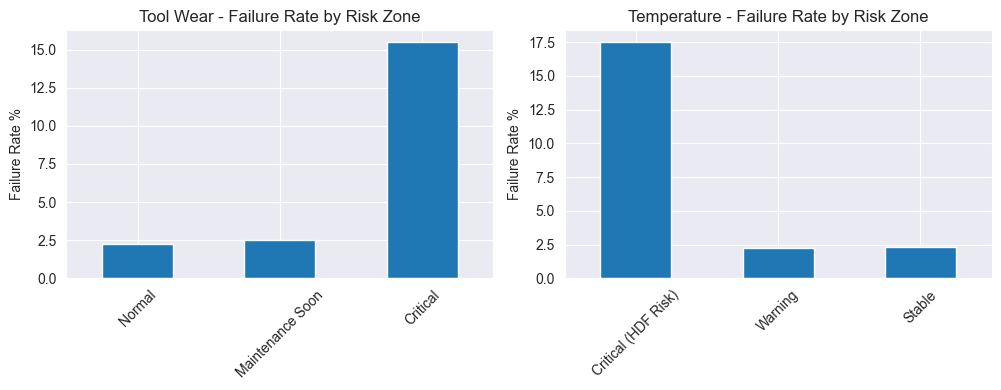

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, risk_col, title in zip(axes, ['Tool_Wear_Risk', 'Temp_Risk'], ['Tool Wear', 'Temperature']):
    rates = df.groupby(risk_col)[MACHINE_FAILURE_COL].mean() * 100
    rates.plot(kind='bar', ax=ax)
    ax.set_title(f'{title} - Failure Rate by Risk Zone')
    ax.set_ylabel('Failure Rate %')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Risk Segmentation Conclusion
Yes, risk segmentation meaningfully separates failure probability:
- **Tool Wear Critical** zone: 15.5% failure rate vs 2.2% in Normal (7x higher)
- **Temperature Critical (HDF Risk)** zone: 17.5% failure rate vs 2.3% in Stable (7.5x higher)
- Both risk indicators successfully identify high-risk machines before failure

## Phase 5 - Data Preparation for Production

In [133]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[NUMERIC_FEATURES] = scaler.fit_transform(df[NUMERIC_FEATURES])
df_scaled[NUMERIC_FEATURES].describe().round(2)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,10000.00,10000.00,10000.00,10000.00,10000.00
mean,-0.00,0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00
min,-2.35,-2.90,-2.07,-3.63,-1.70
25%,-0.85,-0.81,-0.65,-0.68,-0.86
50%,0.05,0.06,-0.20,0.01,0.00
75%,0.75,0.74,0.41,0.68,0.85
max,2.25,2.56,7.51,3.67,2.28


In [134]:
print("Class distribution:")
print(df[MACHINE_FAILURE_COL].value_counts())
print(f"\nImbalance ratio: {df[MACHINE_FAILURE_COL].value_counts()[0] / df[MACHINE_FAILURE_COL].value_counts()[1]:.1f}:1")

Class distribution:
Machine failure
0    9661
1     339
Name: count, dtype: int64

Imbalance ratio: 28.5:1


In [135]:
# 30% stratified sampling
from sklearn.model_selection import train_test_split
_, sample_df = train_test_split(df, test_size=0.3, stratify=df[MACHINE_FAILURE_COL], random_state=42)

print(f"Full dataset: {len(df)}, Sample: {len(sample_df)}")
print(f"\nSample class distribution:")
print(sample_df[MACHINE_FAILURE_COL].value_counts())

Full dataset: 10000, Sample: 3000

Sample class distribution:
Machine failure
0    2898
1     102
Name: count, dtype: int64


In [136]:
comparison = pd.DataFrame({
    'Full_Mean': df[NUMERIC_FEATURES].mean(),
    'Sample_Mean': sample_df[NUMERIC_FEATURES].mean(),
    'Full_Std': df[NUMERIC_FEATURES].std(),
    'Sample_Std': sample_df[NUMERIC_FEATURES].std()
}).round(2)
comparison

,Full_Mean,Sample_Mean,Full_Std,Sample_Std
Air temperature [K],300.00,299.98,2.00,1.99
Process temperature [K],310.01,310.00,1.48,1.49
Rotational speed [rpm],1538.78,1537.70,179.28,177.06
Torque [Nm],39.99,39.95,9.97,9.88
Tool wear [min],107.95,108.72,63.65,63.17


### Bias Risks for Model Training
- **Class imbalance**: 28.5:1 ratio (9661 normal vs 339 failures) - model may ignore minority class
- **Temporal bias**: If UDI represents time order, random sampling may miss wear progression patterns
- **Selection bias**: Stratified sampling preserves 3.4% failure rate but may not preserve sensor correlations
- **Mitigation**: Use SMOTE/ADASYN for oversampling, class weights, or ensemble methods with balanced subsets